# Rotinas para a detecção das não-bijetividades

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

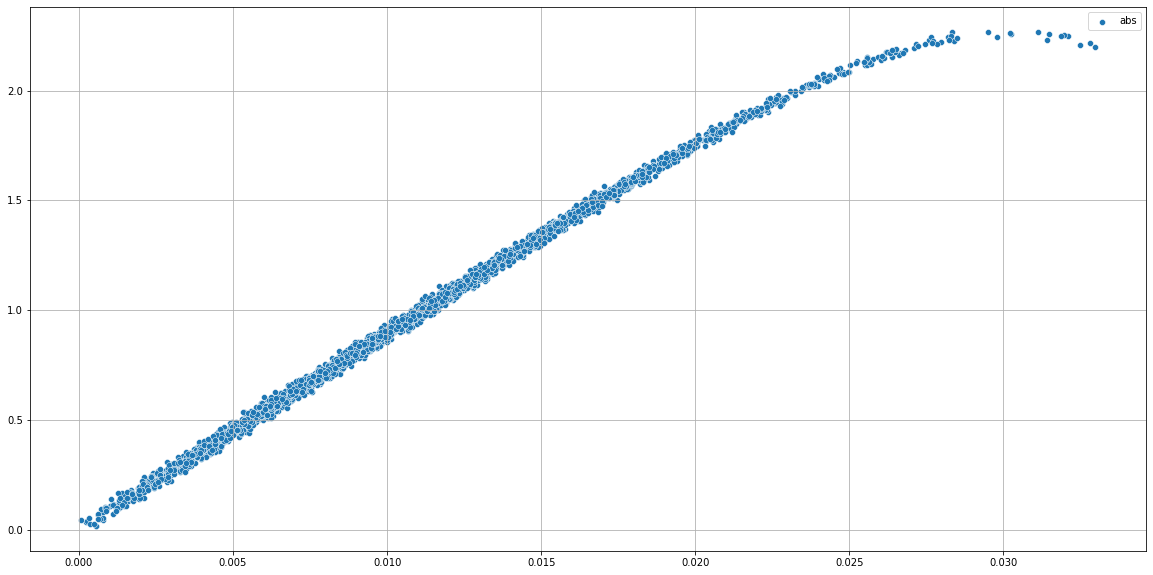

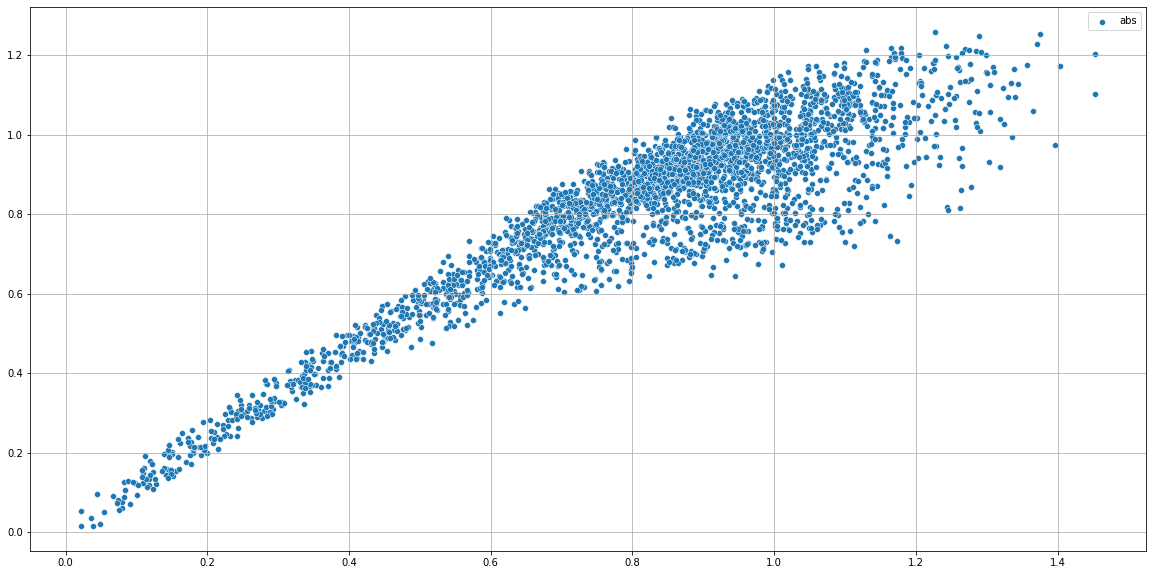

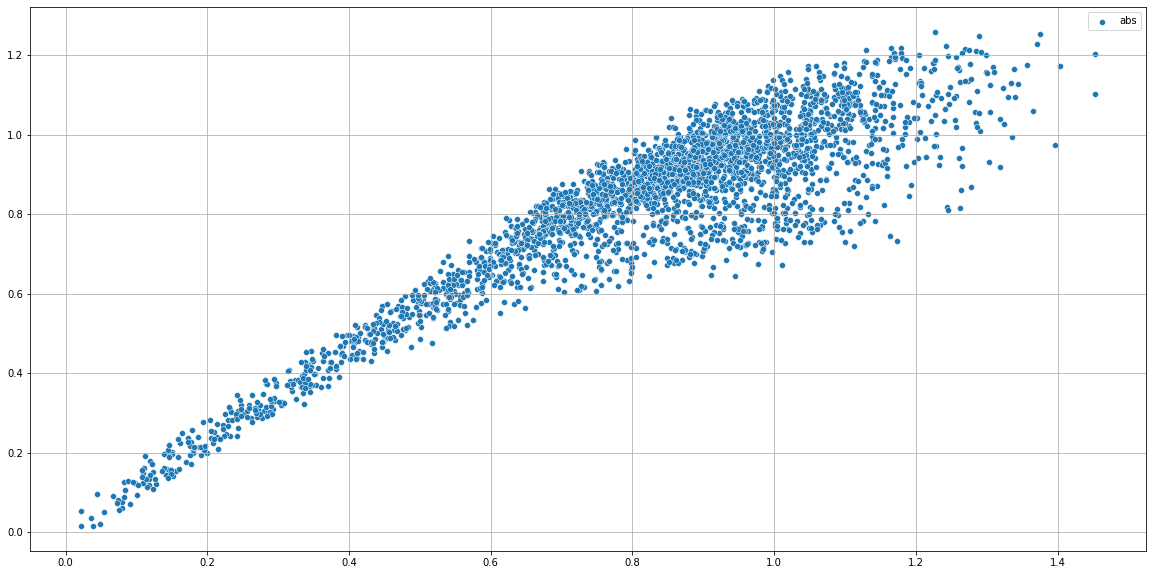

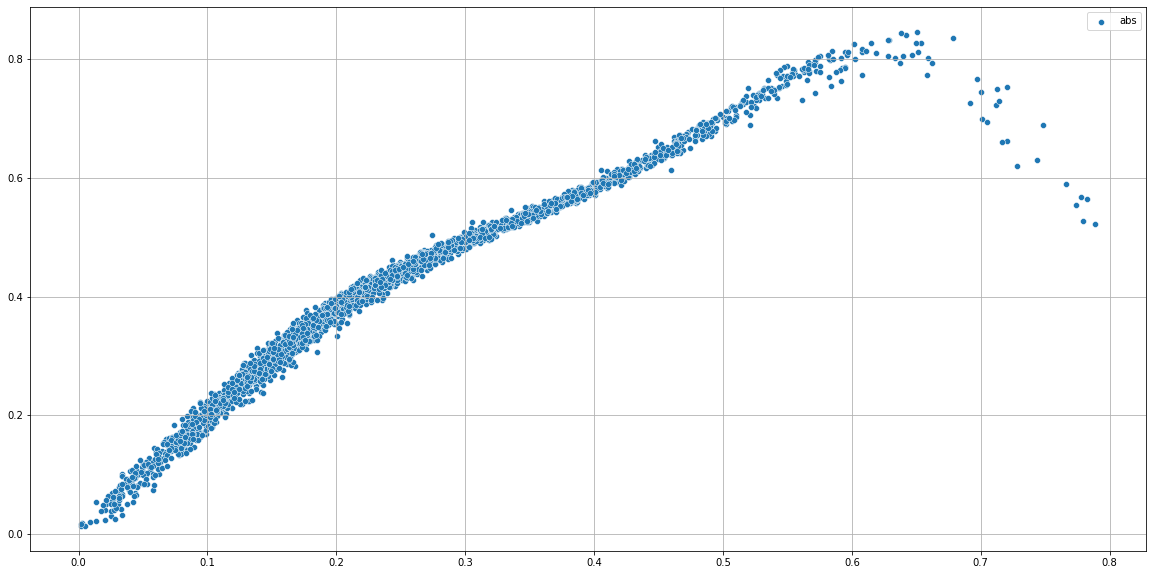

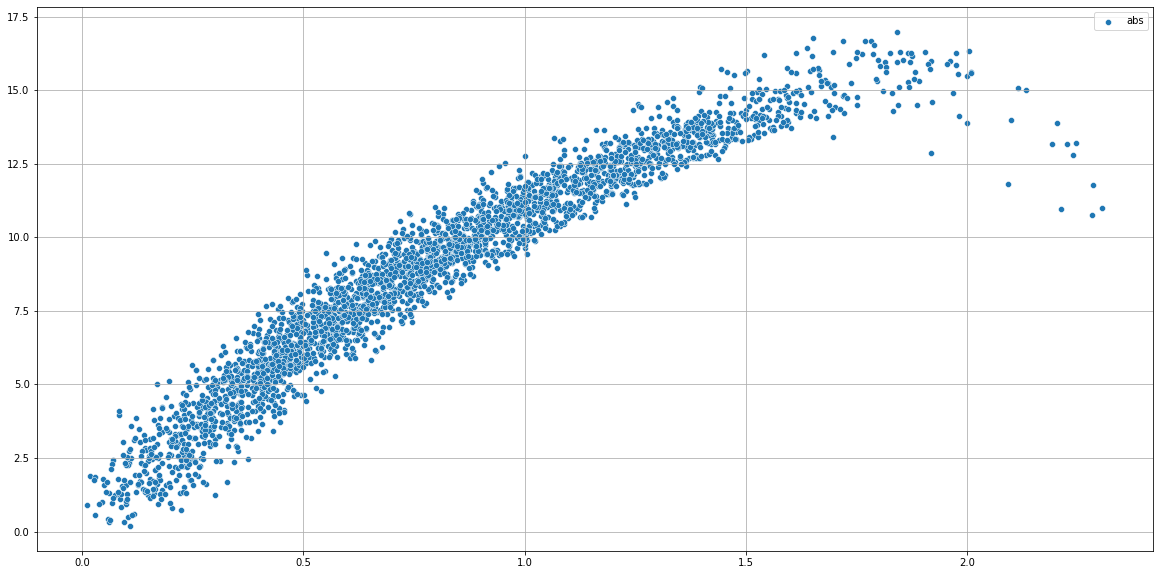

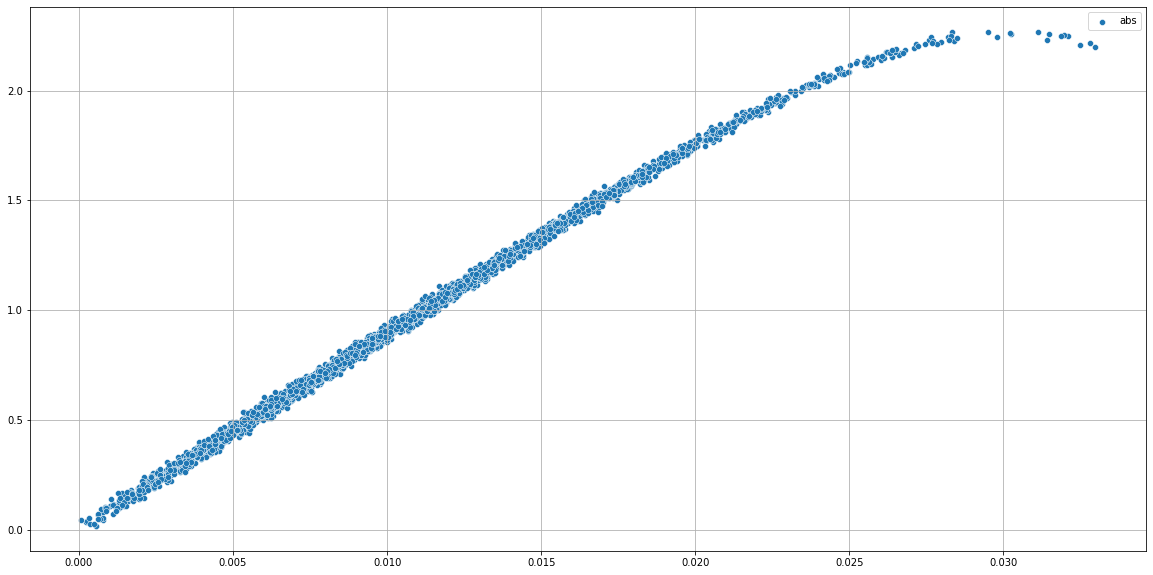

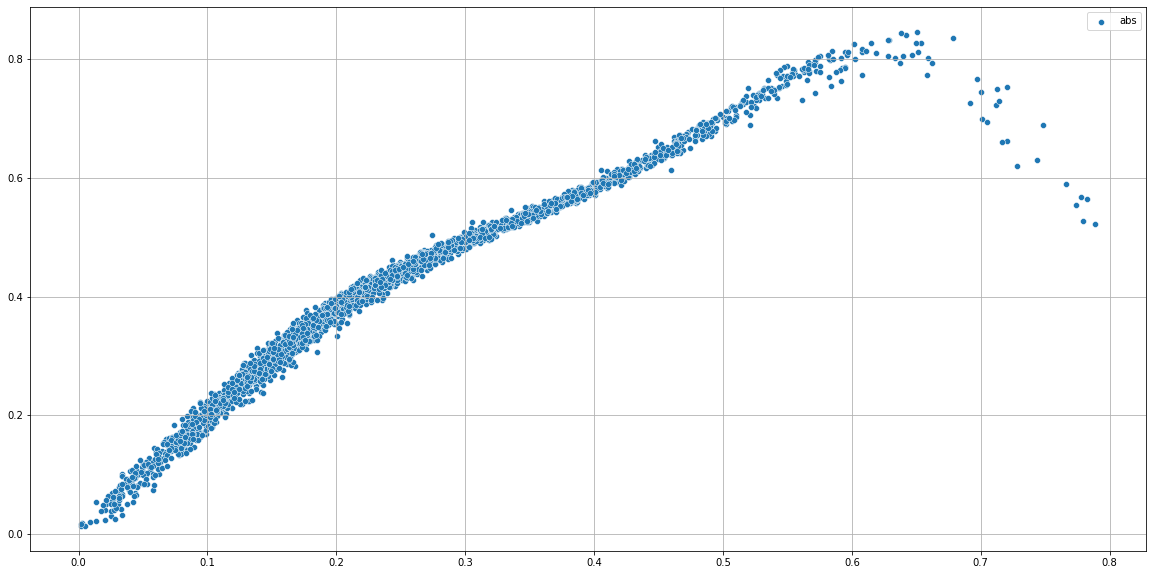

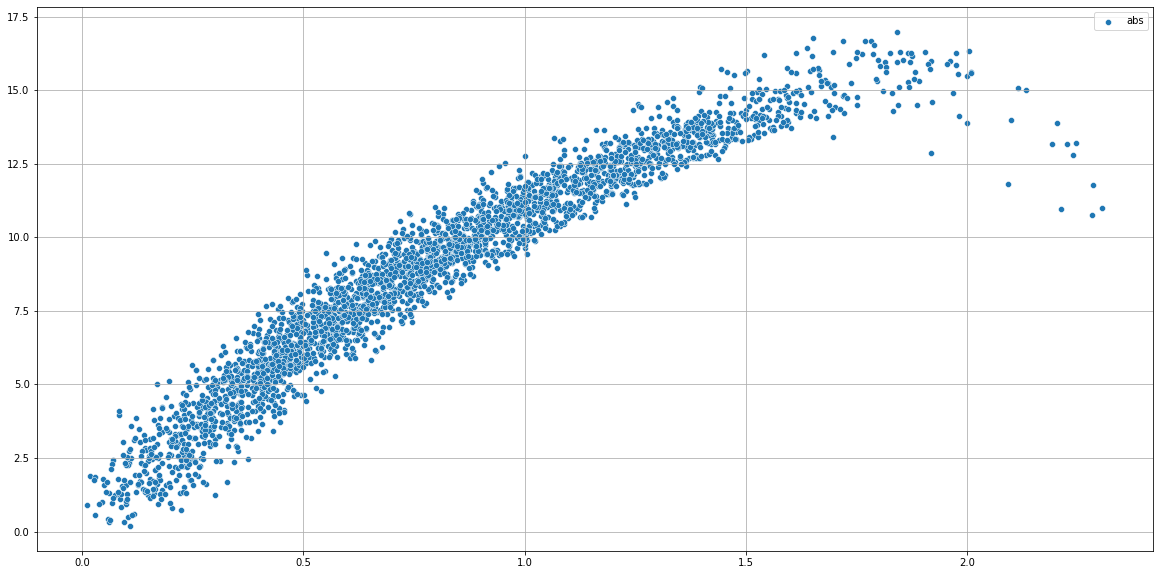

In [5]:
for p in Path().glob('../data/*.csv'):
    data = load_csv2numpy(p)
    x_real = data[:, 0]
    x_imag = data[:, 1]
    x_abs = np.abs(x_real + 1j * x_imag)
    y_real = data[:, 2]
    y_imag = data[:, 3]
    y_abs = np.abs(y_real + 1j * y_imag)
    plt.figure(figsize=(20,10))
    #sns.scatterplot(x=y_abs, y=x_imag, label='imag')
    #sns.scatterplot(x=y_abs, y=x_real, label='real')
    #sns.scatterplot(x=y_abs, y=x_abs, label='abs')
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.show()
    plt.close()